## Fully Connected Neural Network on MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
class NeuralNetwork:
    def __init__(self,n_0, hidden_layers, n_L):
        model = {}
        hidden_layers.insert(0,n_0)  # hidden layers has no. of neurons in each hidd.layer (type list)
        L = len(hidden_layers)
        for l in range(1,L):
            n_l = hidden_layers[l]
            n_l_minus_1 = hidden_layers[l-1]
            model['W'+str(l)] = np.random.randn(n_l,n_l_minus_1)
            model['b'+str(l)] = np.zeros((n_l,1))
        # output layer
        model['W'+str(L)] = np.random.randn(n_L,hidden_layers[L-1])
        model['b'+str(L)] = np.zeros((n_L,1))
        self.model = model
        self.activation_outputs = None
        self.L = L
        self.n_L = n_L
    
    def forward(self,X):
        L = self.L
        activation_outputs = [(1,X)] # 1 means nothing since it wont be used anywhere
        for l in range(1,L):
            W_l = 'W'+str(l)
            b_l = 'b'+str(l)
            Z_l = self.model[W_l].dot(activation_outputs[l-1][1]) + self.model[b_l]
            A_l = np.tanh(Z_l)
            activation_outputs.append((Z_l,A_l))
        Z_L = np.dot(self.model['W'+str(L)], activation_outputs[L-1][1]) + self.model['b'+str(L)]
        A_L = self.softmax(Z_L)
        activation_outputs.append((Z_L,A_L))
        self.activation_outputs = activation_outputs
        return A_L
    
    def backward(self,X,Y,lr,alpha,beeta):
        activation_outputs = self.activation_outputs
        L = self.L
        dZ_L = activation_outputs[L][1] - Y
        A_L_minus_1 = activation_outputs[L-1][1]
        dW_L = ( dZ_L.dot(A_L_minus_1.T) ) + alpha*self.model['W'+str(L)] + beeta*np.sign(self.model['W'+str(L)])
        db_L = np.sum(dZ_L,axis=1,keepdims=True) + alpha*self.model['b'+str(L)] + beeta*np.sign(self.model['b'+str(L)])
        dZlist = [dZ_L]
        dWlist = [dW_L]
        dblist = [db_L]
        l = L-1
        while l>=1:
            W_lplus1 = self.model['W'+str(l+1)]
            dZ_l = W_lplus1.T.dot(dZlist[0])
            dZ_l *= ( 1 - np.square(activation_outputs[l][1])  )
            dW_l = ( dZ_l.dot(activation_outputs[l-1][1].T) ) + alpha*self.model['W'+str(l)] + beeta*np.sign(self.model['W'+str(l)])
            db_l = np.sum(dZ_l,axis=1,keepdims=True)+ alpha*self.model['b'+str(l)] + beeta*np.sign(self.model['b'+str(l)])
            self.model['W'+str(l+1)] -= lr*dWlist[0]
            self.model['b'+str(l+1)] -= lr*dblist[0]
            dZlist.insert(0,dZ_l)
            dWlist.insert(0,dW_l)
            dblist.insert(0,db_l)
            l = l-1
    
    def start_training(self, X_train, Y_train, X_test, Y_test, batchsize, epochs, lr, alpha, beeta):
        train_loss, test_loss, train_acc, test_acc = [],[],[],[]
        n_L = self.n_L
        for epoch in range(epochs):
#             print('epoch',epoch)
            l,a = self.train(X_train, Y_train, batchsize, lr, alpha, beeta)
            train_loss.append(l)
            train_acc.append(a)
            l,a = self.test(X_test, Y_test, batchsize)
            test_loss.append(l)
            test_acc.append(a)
#             print(train_loss[-1],train_acc[-1])
#             print(test_loss[-1],test_loss[-1])
        return train_loss, test_loss, train_acc, test_acc
            
    def train(self, X, Y, batchsize, lr,alpha,beeta):
        n=X.shape[1] #number of samples
        n_L = self.n_L
        l,a=[],[]
        for batch in range(0,n,batchsize):
            X_mini = X[:,batch:batch+batchsize]
            Y_mini = Y[:,batch:batch+batchsize]  
            Y_ = self.forward(X_mini)
            Y_ = np.clip(Y_, a_min = 10**-7, a_max = 1-(10**-7))
            Y_HOT = self.HOT_Vector(Y_mini,n_L)
            l.append(self.Loss(Y_HOT,Y_))
            a.append(100*np.sum(Y_mini==np.argmax(Y_,axis=0))/Y_mini.shape[1])
            self.backward(X_mini,Y_HOT,lr,alpha,beeta)
        return np.array(l).mean(),np.array(a).mean()
    
    def test(self, X, Y, batchsize):
        n=X.shape[1] #number of samples
        n_L = self.n_L
        l,a=[],[]
        for batch in range(0,n,batchsize):
            X_mini = X[:,batch:batch+batchsize]
            Y_mini = Y[:,batch:batch+batchsize]
            Y_ = self.forward(X_mini)
            Y_ = np.clip(Y_, a_min = 10**-7, a_max = 1-(10**-7))
            Y_HOT = self.HOT_Vector(Y_mini,n_L)
            l.append(self.Loss(Y_HOT,Y_))
            a.append(100*np.sum(Y_mini==np.argmax(Y_,axis=0))/Y_mini.shape[1])
        return np.array(l).mean(),np.array(a).mean()
    
    def Predict(self,X):
        return np.argmax(self.forward(X), axis=0)
    
    def Loss(self,Y_hot,Y_):
        return -1*np.mean(Y_hot*np.log(Y_))
    
    def HOT_Vector(self,Y,n_L):
        Y_hot = np.zeros((n_L,Y.shape[1]))
        Y_hot[Y,np.arange(Y.shape[1])] = 1
        return Y_hot
    
    def softmax(self,Z_L):
        y_ = np.exp(Z_L)
        norm = np.sum(y_,axis=0,keepdims=True)
        y_ = y_/norm
        return y_

In [3]:
X_train,Y_train=np.load('./MNIST/train_x.npy').reshape((60000,-1)).T, np.load('./MNIST/train_y.npy').reshape((1,-1))
X_test,Y_test=np.load('./MNIST/test_x.npy').reshape((10000,-1)).T, np.load('./MNIST/test_y.npy').reshape((1,-1))
# mean=X_train.mean(axis=1,keepdims=True)
# std=X_train.std(axis=1,keepdims=True)
#no normalisation since lot of zeros in mnist
nn = NeuralNetwork(n_0=784,hidden_layers=[512,128],n_L=10)
train_loss, test_loss, train_acc, test_acc = nn.start_training(X_train,Y_train,X_test,Y_test,128,epochs=25,lr=.1,alpha=0,beeta=0)
np.save('mlp_1.npy',np.array([train_loss, test_loss, train_acc, test_acc]))

 
epoch 1
0.5681717046606007 85.545
0.30408342955987666 91.48
epoch 2
0.2882579162812182 91.62833333333333
0.2599036654433872 92.4
epoch 3
0.24716595533305902 92.86666666666666
0.22363485169561603 93.43
epoch 4
0.21545398548277203 93.75666666666666
0.19884566783527785 94.07
epoch 5
0.18795421287449185 94.535
0.17493931430427334 94.74
epoch 6
0.16639754835412954 95.16333333333333
0.1555949142084846 95.42
epoch 7
0.14889972186736714 95.69
0.15008557092728494 95.67
epoch 8
0.13459693533239334 96.05833333333334
0.1337103582447088 96.09
epoch 9
0.12208094952234835 96.435
0.1247842203401312 96.28
epoch 10
0.11176493002185181 96.75166666666667
0.11944846658012535 96.28
epoch 11
0.10339562532140502 97.03166666666667
0.1131509076096589 96.61
epoch 12
0.09526606888246181 97.30166666666666
0.10478019367762004 96.69
epoch 13
0.08856005262114855 97.42333333333333
0.09951929913102826 96.93
epoch 14
0.08257563755726383 97.635
0.09504855721245838 96.97
epoch 15
0.07674233342157498 97.81666666666666
0.

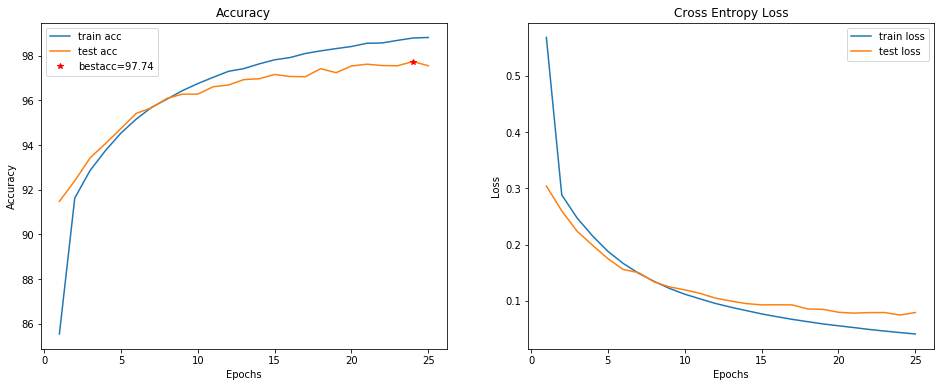

In [44]:
mlp_1=np.load('mlp1.npy')
epochs=np.arange(1,mlp_1.shape[1]+1,1)
plt.figure(figsize=(16.,6.))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,mlp_1[2],label='train acc')
plt.plot(epochs,mlp_1[3],label='test acc')
ep=np.argmax(mlp_1[3,:])
plt.plot(ep+1,mlp_1[3,ep],'r*',label='bestacc=%.2f'%mlp_1[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,mlp_1[0],label='train loss')
plt.plot(epochs,mlp_1[1],label='test loss')
plt.legend()
plt.savefig('mlp1.png')
plt.show()

In [14]:
for i,lr in enumerate([1,0.1,0.01]):
    train_loss, test_loss, train_acc, test_acc = nn.start_training(X_train,Y_train,X_test,Y_test,512,epochs=25,lr=.01,alpha=5e-4,beeta=0)
    np.save('mlp_%u.npy'%i,np.array([train_loss, test_loss, train_acc, test_acc]))

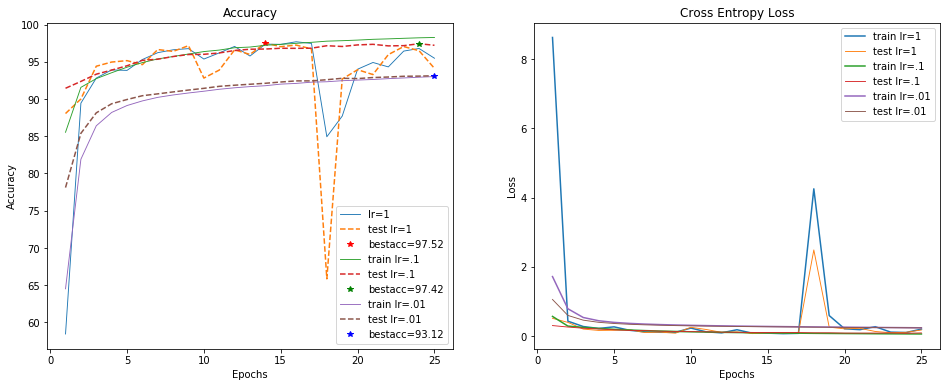

In [16]:
mlp_lr1=np.load('mlp_lr1.npy')
mlp_lr2=np.load('mlp_lr2.npy')
mlp_lr3=np.load('mlp_lr3.npy')
epochs=np.arange(1,mlp_lr1.shape[1]+1,1)
plt.figure(figsize=(16.,6.))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,mlp_lr1[2],label='lr=1',linewidth=0.9)
plt.plot(epochs,mlp_lr1[3],label='test lr=1',linestyle='--')
ep=np.argmax(mlp_lr1[3,:])
plt.plot(ep+1,mlp_lr1[3,ep],'r*',label='bestacc=%.2f'%mlp_lr1[3,ep])
plt.plot(epochs,mlp_lr2[2],label='train lr=.1',linewidth=0.9)
plt.plot(epochs,mlp_lr2[3],label='test lr=.1',linestyle='--')
ep=np.argmax(mlp_lr2[3,:])
plt.plot(ep+1,mlp_lr2[3,ep],'g*',label='bestacc=%.2f'%mlp_lr2[3,ep])
plt.plot(epochs,mlp_lr3[2],label='train lr=.01',linewidth=0.9)
plt.plot(epochs,mlp_lr3[3],label='test lr=.01',linestyle='--')
ep=np.argmax(mlp_lr3[3,:])
plt.plot(ep+1,mlp_lr3[3,ep],'b*',label='bestacc=%.2f'%mlp_lr3[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,mlp_lr1[0],label='train lr=1')
plt.plot(epochs,mlp_lr1[1],label='test lr=1',linewidth=0.9)
plt.plot(epochs,mlp_lr2[0],label='train lr=.1')
plt.plot(epochs,mlp_lr2[1],label='test lr=.1',linewidth=0.9)
plt.plot(epochs,mlp_lr3[0],label='train lr=.01')
plt.plot(epochs,mlp_lr3[1],label='test lr=.01',linewidth=0.9)
plt.legend()
plt.savefig('mlp_lr.png')
plt.show()

### Dropout

In [31]:
class NeuralNetwork:
    def __init__(self,n_0, hidden_layers, n_L, dropout_layers):
        '''
        dropout_layers = [p for i/p layer, p for layer 1, .. , p for L-1 layer]
        dropout on output layer is not allowed/meaningless!
        '''
        model = {}
        hidden_layers.insert(0,n_0)  # hidden layers has no. of neurons in each hidd.layer (type list)
        L = len(hidden_layers)
        for l in range(1,L):
            n_l = hidden_layers[l]
            n_l_minus_1 = hidden_layers[l-1]
            model['W'+str(l)] = np.random.randn(n_l,n_l_minus_1)
            model['b'+str(l)] = np.zeros((n_l,1))
        model['W'+str(L)] = np.random.randn(n_L,hidden_layers[L-1])
        model['b'+str(L)] = np.zeros((n_L,1))
        self.model = model
        self.activation_outputs = None
        self.L = L
        self.n_L = n_L
        self.dropout_layers = dropout_layers
        self.hidden_layers = hidden_layers
    
    def forward(self,X,train=False):
        L = self.L
        if train==True: #dropout only during training
            neurons_to_drop = np.random.uniform(0,1,self.hidden_layers[0])<=self.dropout_layers[0]
            X[neurons_to_drop]=0
        activation_outputs = [(1,X)] # 1 means nothing since it wont be used anywhere
        for l in range(1,L):
            W_l = 'W'+str(l)
            b_l = 'b'+str(l)
            Z_l = self.model[W_l].dot(activation_outputs[l-1][1]) + self.model[b_l]
            A_l = np.tanh(Z_l)
            if train==True:
                neurons_to_drop = np.random.uniform(0,1,self.hidden_layers[l])<=self.dropout_layers[l]
                A_l[neurons_to_drop]=0
            activation_outputs.append((Z_l,A_l))
        Z_L = np.dot(self.model['W'+str(L)], activation_outputs[L-1][1]) + self.model['b'+str(L)]
        A_L = self.softmax(Z_L)
        activation_outputs.append((Z_L,A_L))
        self.activation_outputs = activation_outputs
        return A_L
    
    def backward(self,X,Y,lr,alpha,beeta):
        activation_outputs = self.activation_outputs
        L = self.L
        dZ_L = activation_outputs[L][1] - Y
        A_L_minus_1 = activation_outputs[L-1][1]
        dW_L = ( dZ_L.dot(A_L_minus_1.T) ) + alpha*self.model['W'+str(L)] + beeta*np.sign(self.model['W'+str(L)])
        db_L = np.sum(dZ_L,axis=1,keepdims=True) + alpha*self.model['b'+str(L)] + beeta*np.sign(self.model['b'+str(L)])
        dZlist = [dZ_L]
        dWlist = [dW_L]
        dblist = [db_L]
        l = L-1
        while l>=1:
            W_lplus1 = self.model['W'+str(l+1)]
            dZ_l = W_lplus1.T.dot(dZlist[0])
            dZ_l *= ( 1 - np.square(activation_outputs[l][1])  )
            dW_l = ( dZ_l.dot(activation_outputs[l-1][1].T) ) + alpha*self.model['W'+str(l)] + beeta*np.sign(self.model['W'+str(l)])
            db_l = np.sum(dZ_l,axis=1,keepdims=True)+ alpha*self.model['b'+str(l)] + beeta*np.sign(self.model['b'+str(l)])
            self.model['W'+str(l+1)] -= lr*dWlist[0]
            self.model['b'+str(l+1)] -= lr*dblist[0]
            dZlist.insert(0,dZ_l)
            dWlist.insert(0,dW_l)
            dblist.insert(0,db_l)
            l = l-1
    
    def start_training(self, X_train, Y_train, X_test, Y_test, batchsize, epochs, lr, alpha, beeta):
        train_loss, test_loss, train_acc, test_acc = [],[],[],[]
        n_L = self.n_L
        for epoch in range(epochs):
            print(epoch)
            l,a = self.train(X_train, Y_train, batchsize, lr, alpha, beeta)
            train_loss.append(l)
            train_acc.append(a)
            l,a = self.test(X_test, Y_test, batchsize)
            test_loss.append(l)
            test_acc.append(a)
        return train_loss, test_loss, train_acc, test_acc
            
    def train(self, X, Y, batchsize, lr, alpha, beeta):
        n=X.shape[1] #number of samples
        n_L = self.n_L
        l,a=[],[]
        for batch in range(0,n,batchsize):
            X_mini = X[:,batch:batch+batchsize]
            Y_mini = Y[:,batch:batch+batchsize]  
            Y_ = self.forward(X_mini,train=True)
            Y_ = np.clip(Y_, a_min = 10**-7, a_max = 1-(10**-7))
            Y_HOT = self.HOT_Vector(Y_mini,n_L)
            l.append(self.Loss(Y_HOT,Y_))
            a.append(100*np.sum(Y_mini==np.argmax(Y_,axis=0))/Y_mini.shape[1])
            self.backward(X_mini,Y_HOT,lr,alpha,beeta)
        return np.array(l).mean(),np.array(a).mean()
    
    def test(self, X, Y, batchsize):
        n=X.shape[1] #number of samples
        n_L = self.n_L
        l,a=[],[]
        for batch in range(0,n,batchsize):
            X_mini = X[:,batch:batch+batchsize]
            Y_mini = Y[:,batch:batch+batchsize]
            Y_ = self.forward(X_mini)
            Y_ = np.clip(Y_, a_min = 10**-7, a_max = 1-(10**-7))
            Y_HOT = self.HOT_Vector(Y_mini,n_L)
            l.append(self.Loss(Y_HOT,Y_))
            a.append(100*np.sum(Y_mini==np.argmax(Y_,axis=0))/Y_mini.shape[1])
        return np.array(l).mean(),np.array(a).mean()
    
    def Predict(self,X):
        return np.argmax(self.forward(X), axis=0)
    
    def Loss(self,Y_hot,Y_):
        return -1*np.mean(Y_hot*np.log(Y_))
    
    def HOT_Vector(self,Y,n_L):
        Y_hot = np.zeros((n_L,Y.shape[1]))
        Y_hot[Y,np.arange(Y.shape[1])] = 1
        return Y_hot
    
    def softmax(self,Z_L):
        y_ = np.exp(Z_L)
        norm = np.sum(y_,axis=0,keepdims=True)
        y_ = y_/norm
        return y_

In [34]:
X_train,Y_train=np.load('./MNIST/train_x.npy').reshape((60000,-1)).T, np.load('./MNIST/train_y.npy').reshape((1,-1))
X_test,Y_test=np.load('./MNIST/test_x.npy').reshape((10000,-1)).T, np.load('./MNIST/test_y.npy').reshape((1,-1))
nn = NeuralNetwork(n_0=784,hidden_layers=[512,128],n_L=10,dropout_layers=[0.5,0.5,0.5])
train_loss, test_loss, train_acc, test_acc = nn.start_training(X_train,Y_train,X_test,Y_test,128,epochs=1,lr=.1,alpha=5e-4,beeta=0)
np.save('mlp_dp.npy',np.array([train_loss, test_loss, train_acc, test_acc]))

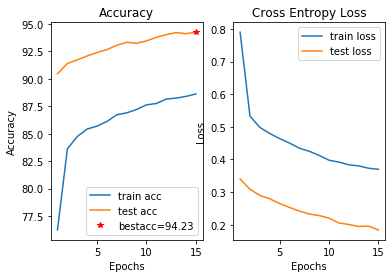

In [36]:
mlp_dp=np.load('mlp_dp.npy')
epochs=np.arange(1,mlp_dp.shape[1]+1,1)
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,mlp_dp[2],label='train acc')
plt.plot(epochs,mlp_dp[3],label='test acc')
ep=np.argmax(mlp_dp[3,:])
plt.plot(ep+1,mlp_dp[3,ep],'r*',label='bestacc=%.2f'%mlp_dp[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,mlp_dp[0],label='train loss')
plt.plot(epochs,mlp_dp[1],label='test loss')
plt.legend()
plt.show()

### Batch Normalization

In [39]:
class NeuralNetwork:
    def __init__(self,n_0, hidden_layers, n_L):
        model = {}
        hidden_layers.insert(0,n_0)  # hidden layers has no. of neurons in each hidd.layer (type list)
        L = len(hidden_layers)
        for l in range(1,L):
            n_l = hidden_layers[l]
            n_l_minus_1 = hidden_layers[l-1]
            model['W'+str(l)] = np.random.randn(n_l,n_l_minus_1)
            model['b'+str(l)] = np.zeros((n_l,1))
        # output layer
        model['W'+str(L)] = np.random.randn(n_L,hidden_layers[L-1])
        model['b'+str(L)] = np.zeros((n_L,1))
        self.model = model
        self.activation_outputs = None
        self.L = L
        self.n_L = n_L
        
        self.gamma=np.ones((L-1))
        self.beta=np.zeros((L-1))
        self.mean_minibatch=[0]*(L-1)
        self.std_minibatch=[0]*(L-1)
    
    def forward(self,X,is_train=False):
        L = self.L
        activation_outputs = [(1,X)] # 1 means nothing since it wont be used anywhere
        for l in range(1,L):
            W_l = 'W'+str(l)
            b_l = 'b'+str(l)
            Z_l = self.model[W_l].dot(activation_outputs[l-1][1]) + self.model[b_l]
            
            #batch norm Z_l
            if is_train==True:
                mean_minibatch = Z_l.mean(axis=1,keepdims=True)
                std_minibatch = Z_l.std(axis=1,keepdims=True)
                self.mean_minibatch[l]=mean_minibatch
                self.std_minibatch[l]=std_minibatch
            else:
                mean_minibatch=self.mean_minibatch[l]
                std_minibatch=self.std_minibatch[l]
            Z_l-=mean_minibatch
            Z_l/=std_minibatch
            Z_l=self.gamma[l]*Z_l+self.beta[l]
            
            A_l = np.tanh(Z_l)
            activation_outputs.append((Z_l,A_l))
        Z_L = np.dot(self.model['W'+str(L)], activation_outputs[L-1][1]) + self.model['b'+str(L)]
        A_L = self.softmax(Z_L)
        activation_outputs.append((Z_L,A_L))
        self.activation_outputs = activation_outputs
        return A_L
    
    def backward(self,X,Y,lr,alpha,beeta):
        activation_outputs = self.activation_outputs
        L = self.L
        dZ_L = activation_outputs[L][1] - Y
        A_L_minus_1 = activation_outputs[L-1][1]
        dW_L = ( dZ_L.dot(A_L_minus_1.T) ) + alpha*self.model['W'+str(L)] + beeta*np.sign(self.model['W'+str(L)])
        db_L = np.sum(dZ_L,axis=1,keepdims=True) + alpha*self.model['b'+str(L)] + beeta*np.sign(self.model['b'+str(L)])
        dZlist = [dZ_L]
        dWlist = [dW_L]
        dblist = [db_L]
        l = L-1
        while l>=1:
            W_lplus1 = self.model['W'+str(l+1)]
            dZ_l = W_lplus1.T.dot(dZlist[0])
            dZ_l *= ( 1 - np.square(activation_outputs[l][1])  )
            dW_l = ( dZ_l.dot(activation_outputs[l-1][1].T) ) + alpha*self.model['W'+str(l)] + beeta*np.sign(self.model['W'+str(l)])
            db_l = np.sum(dZ_l,axis=1,keepdims=True)+ alpha*self.model['b'+str(l)] + beeta*np.sign(self.model['b'+str(l)])
            dgamma_l = dZ_l.dot(activation_outputs[l-1][1].T)
            dbeta_l = dZ_l
            self.gamma[l]=-lr*dgamma_l
            self.beta[l]=-lr*dbeta_l
            self.model['W'+str(l+1)] -= lr*dWlist[0]
            self.model['b'+str(l+1)] -= lr*dblist[0]
            dZlist.insert(0,dZ_l)
            dWlist.insert(0,dW_l)
            dblist.insert(0,db_l)
            l = l-1
    
    def start_training(self, X_train, Y_train, X_test, Y_test, batchsize, epochs, lr, alpha, beeta):
        train_loss, test_loss, train_acc, test_acc = [],[],[],[]
        n_L = self.n_L
        for epoch in range(epochs):
            print('epoch',epoch,end='\r')
            l,a = self.train(X_train, Y_train, batchsize, lr, alpha, beeta)
            train_loss.append(l)
            train_acc.append(a)
            l,a = self.test(X_test, Y_test, batchsize)
            test_loss.append(l)
            test_acc.append(a)
        return train_loss, test_loss, train_acc, test_acc
            
    def train(self, X, Y, batchsize, lr, alpha, beeta):
        n=X.shape[1] #number of samples
        n_L = self.n_L
        l,a=[],[]
        for batch in range(0,n,batchsize):
            X_mini = X[:,batch:batch+batchsize]
            Y_mini = Y[:,batch:batch+batchsize]  
            Y_ = self.forward(X_mini,is_train=True)
            Y_ = np.clip(Y_, a_min = 10**-7, a_max = 1-(10**-7))
            Y_HOT = self.HOT_Vector(Y_mini,n_L)
            l.append(self.Loss(Y_HOT,Y_))
            a.append(100*np.sum(Y_mini==np.argmax(Y_,axis=0))/Y_mini.shape[1])
            self.backward(X_mini,Y_HOT,lr, alpha, beeta)
        return np.array(l).mean(),np.array(a).mean()
    
    def test(self, X, Y, batchsize):
        n=X.shape[1] #number of samples
        n_L = self.n_L
        l,a=[],[]
        for batch in range(0,n,batchsize):
            X_mini = X[:,batch:batch+batchsize]
            Y_mini = Y[:,batch:batch+batchsize]
            Y_ = self.forward(X_mini)
            Y_ = np.clip(Y_, a_min = 10**-7, a_max = 1-(10**-7))
            Y_HOT = self.HOT_Vector(Y_mini,n_L)
            l.append(self.Loss(Y_HOT,Y_))
            a.append(100*np.sum(Y_mini==np.argmax(Y_,axis=0))/Y_mini.shape[1])
        return np.array(l).mean(),np.array(a).mean()
    
    def Predict(self,X):
        return np.argmax(self.forward(X), axis=0)
    
    def Loss(self,Y_hot,Y_):
        return -1*np.mean(Y_hot*np.log(Y_))
    
    def HOT_Vector(self,Y,n_L):
        Y_hot = np.zeros((n_L,Y.shape[1]))
        Y_hot[Y,np.arange(Y.shape[1])] = 1
        return Y_hot
    
    def softmax(self,Z_L):
        y_ = np.exp(Z_L)
        norm = np.sum(y_,axis=0,keepdims=True)
        y_ = y_/norm
        return y_

In [40]:
X_train,Y_train=np.load('./MNIST/train_x.npy').reshape((60000,-1)).T, np.load('./MNIST/train_y.npy').reshape((1,-1))
X_test,Y_test=np.load('./MNIST/test_x.npy').reshape((10000,-1)).T, np.load('./MNIST/test_y.npy').reshape((1,-1))
nn = NeuralNetwork(n_0=784,hidden_layers=[512,128],n_L=10)
train_loss, test_loss, train_acc, test_acc = nn.start_training(X_train,Y_train,X_test,Y_test,128,epochs=1,lr=.1,alpha=5e-4,beeta=0)
np.save('mlp_bn.npy',np.array([train_loss, test_loss, train_acc, test_acc]))

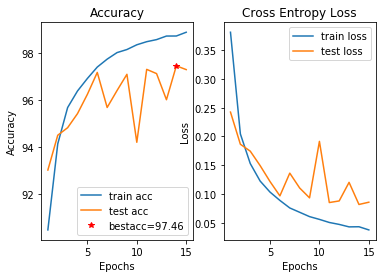

In [41]:
mlp_bn=np.load('mlp_bn.npy')
epochs=np.arange(1,mlp_bn.shape[1]+1,1)
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,mlp_bn[2],label='train acc')
plt.plot(epochs,mlp_bn[3],label='test acc')
ep=np.argmax(mlp_bn[3,:])
plt.plot(ep+1,mlp_bn[3,ep],'r*',label='bestacc=%.2f'%mlp_bn[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,mlp_bn[0],label='train loss')
plt.plot(epochs,mlp_bn[1],label='test loss')
plt.legend()
plt.show()

### BatchNorm + Dropout

In [42]:
X_train,Y_train=np.load('./MNIST/train_x.npy').reshape((60000,-1)).T, np.load('./MNIST/train_y.npy').reshape((1,-1))
X_test,Y_test=np.load('./MNIST/test_x.npy').reshape((10000,-1)).T, np.load('./MNIST/test_y.npy').reshape((1,-1))
nn = NeuralNetwork(n_0=784,hidden_layers=[512,128],n_L=10,dropout_layers=[0.5,0.5,0.5])
train_loss, test_loss, train_acc, test_acc = nn.start_training(X_train,Y_train,X_test,Y_test,128,epochs=1,lr=.1,alpha=5e-4,beeta=0)
np.save('mlp_dp_bn.npy',np.array([train_loss, test_loss, train_acc, test_acc]))

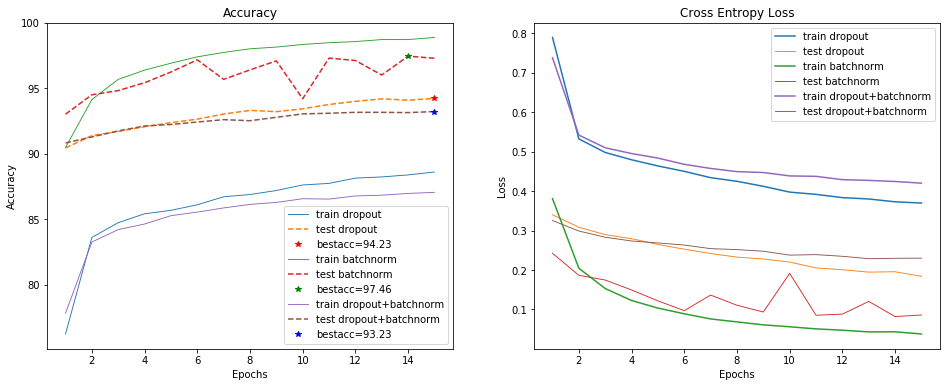

In [43]:
mlp_dp=np.load('mlp_dp.npy')
mlp_bn=np.load('mlp_bn.npy')
mlp_dp_bn=np.load('mlp_dp_bn.npy')
epochs=np.arange(1,mlp_dp_bn.shape[1]+1,1)
plt.figure(figsize=(16.,6.))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,mlp_dp[2],label='train dropout',linewidth=0.9)
plt.plot(epochs,mlp_dp[3],label='test dropout',linestyle='--')
ep=np.argmax(mlp_dp[3,:])
plt.plot(ep+1,mlp_dp[3,ep],'r*',label='bestacc=%.2f'%mlp_dp[3,ep])
plt.plot(epochs,mlp_bn[2],label='train batchnorm',linewidth=0.9)
plt.plot(epochs,mlp_bn[3],label='test batchnorm',linestyle='--')
ep=np.argmax(mlp_bn[3,:])
plt.plot(ep+1,mlp_bn[3,ep],'g*',label='bestacc=%.2f'%mlp_bn[3,ep])
plt.plot(epochs,mlp_dp_bn[2],label='train dropout+batchnorm',linewidth=0.9)
plt.plot(epochs,mlp_dp_bn[3],label='test dropout+batchnorm',linestyle='--')
ep=np.argmax(mlp_dp_bn[3,:])
plt.plot(ep+1,mlp_dp_bn[3,ep],'b*',label='bestacc=%.2f'%mlp_dp_bn[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,mlp_dp[0],label='train dropout')
plt.plot(epochs,mlp_dp[1],label='test dropout',linewidth=0.9)
plt.plot(epochs,mlp_bn[0],label='train batchnorm')
plt.plot(epochs,mlp_bn[1],label='test batchnorm',linewidth=0.9)
plt.plot(epochs,mlp_dp_bn[0],label='train dropout+batchnorm')
plt.plot(epochs,mlp_dp_bn[1],label='test dropout+batchnorm',linewidth=0.9)
plt.legend()
plt.savefig('mlp_regularizers.png')
plt.show()

# Convolutional Neural Networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
import numpy as np

class Tiny_ImageNet(Dataset):
    def __init__(self,train=True):
        self.train = train
        type_ = 'train' if train else 'test'
        Images_path='TinyImageNet/'+type_+'_x.npy'
        Labels_path='TinyImageNet/'+type_+'_y.npy'
        self.imgs=np.load(Images_path).transpose(0,2,3,1)
        self.lbls=np.load(Labels_path)
        print("Data Successfully Loaded into CPU")

        # Normalizing the data
        # self.mean=np.zeros((3,1))
        # self.std=np.zeros((3,1))
        # for i in range(self.data.shape[0]):
        #     for j in range(3):
        #         self.mean[j,0]+=self.data[i,:,:,j].mean()
        #         self.std[j,0]+=self.data[i,:,:,j].std()
        # self.mean/=255*self.data.shape[0]
        # self.std/=255*self.data.shape[0]
        # print(self.mean)
        # print(self.std)
        # Computed the mean and stddev using train set : will apply it on both train and test set
        self.mean = (0.48093379,0.44808328,0.39650237)
        self.stddev = (0.22996924,0.22610814,0.22566715)

    def __getitem__(self, index):
        img, target = self.imgs[index], self.lbls[index]
        img = Image.fromarray(img.astype(np.uint8))

        if self.train == True: # Apply train transform
            t1 = transforms.Compose(
                    [transforms.RandomCrop(64, padding=8), 
                    transforms.RandomHorizontalFlip()])
            img = t1(img)

        t2 = transforms.Compose(
            [transforms.ToTensor(), 
            transforms.Normalize(self.mean, self.stddev)])
        img = t2(img)
        # img = img.half()
        return img, target

    def __len__(self):
        return self.imgs.shape[0]

In [ ]:
#https://github.com/kuangliu/pytorch-cifar
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*13*13, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 200)
    def forward(self, x):
        out = F.relu(self.conv1(x)) #6,60,60
        out = F.max_pool2d(out, 2) #6,30,30
        out = F.relu(self.conv2(out)) #16,26,26
        out = F.max_pool2d(out, 2) #16,13,13
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), #64,15,15
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #64,7,7
            nn.Conv2d(64, 192, kernel_size=5, padding=2), #192,7,7
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #192,3,3
            nn.Conv2d(192, 384, kernel_size=3, padding=1), #384,3,3
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), #256,3,3
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), #256,3,3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), #256,1,1
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 200),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.classifier = nn.Linear(512, 200)
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=2, stride=1)] #changed kernel size from 1 to 2
        return nn.Sequential(*layers)

#### note
the below script is used for all the experiments (lenet, alexnet, vgg, and with different optimizers) by making small changes which are not shown here but were done on run in HPC

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import os
import time
import matplotlib.pyplot as plt
import PIL.Image as Image
import numpy as np
from model import *
from TinyImageNet import *
from torch.utils.data import Dataset, DataLoader

def main():
    exp_name='LeNet_adam'
    torch.manual_seed(1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(torch.cuda.get_device_properties(0))
    # Data
    print('==> Preparing data..')
    trainset = Tiny_ImageNet(train=True)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = Tiny_ImageNet(train=False)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    print('==> Building model..')
    net = LeNet()
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    start_epoch = 1
    best_acc=0
###
    if os.path.exists('%s_checkpoint.pth'%exp_name):
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load('%s_checkpoint.pth'%exp_name)
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
###
    lr=0.001
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=5e-4)
    t=0
    trainloss, testloss, trainacc, testacc = [], [], [], []
    ind=0
    for epoch in range(start_epoch, start_epoch+100):
        print('epoch',epoch)
        ind=ind+1
        if ind==75:
            lr=lr/10.
            optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=5e-4)
        # s=time.time()
        l,a=train(epoch, net, trainloader, device, optimizer, criterion)
        # e=time.time()
        # t+=(e-s)
        trainloss.append(l)
        trainacc.append(a)
        # s=time.time()
        l,a,best_acc=test(epoch, best_acc, net, testloader, device, criterion, exp_name)
        # e=time.time()
        # t+=(e-s)
        testloss.append(l)
        testacc.append(a)
        print(trainloss[-1], trainacc[-1])
        print(testloss[-1], testacc[-1])
    Save_Stats(trainloss, trainacc, testloss, testacc, exp_name)

def train(epoch, net, trainloader, device, optimizer, criterion):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/(batch_idx+1), 100.*correct/total 

def test(epoch, best_acc, net, testloader, device, criterion,exp_name):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, '%s_checkpoint.pth'%exp_name)
        best_acc = acc
    return test_loss/(batch_idx+1), acc, best_acc

def SavePlots(y1, y2, metric, exp_name):
    try:
        plt.clf()
    except Exception as e:
        pass
    plt.style.use('seaborn')
    plt.title(exp_name)
    plt.xlabel('epochs')
    plt.ylabel(metric)
    epochs=np.arange(1,len(y1)+1,1)
    plt.plot(epochs,y1,label='train {}'.format(metric))
    plt.plot(epochs,y2,label='test {}'.format(metric))
    if metric=='acc':
        ep=np.argmax(y2)
        plt.plot(ep+1,y2[ep],'r*',label='bestacc@({},{})'.format(ep+1,y2[ep]))
    plt.legend()
    plt.savefig('{}_{}'.format(exp_name,metric), dpi=95)

def Save_Stats(trainloss, trainacc, testloss, testacc, exp_name):
    data=[]
    data.append(trainloss)
    data.append(testloss)
    data.append(trainacc)
    data.append(testacc)
    data=np.array(data)
    data.reshape((4,-1))
    stats_path = '%s.npy'%exp_name
    if os.path.exists(stats_path):
        data_old = np.load(stats_path)
        data = np.hstack((data_old,data))
    np.save(stats_path,data)

    SavePlots(data[0], data[1], 'loss', exp_name)
    SavePlots(data[2], data[3], 'acc', exp_name)

if __name__ == '__main__':
    main()


In [8]:
import numpy as np
import matplotlib.pyplot as plt

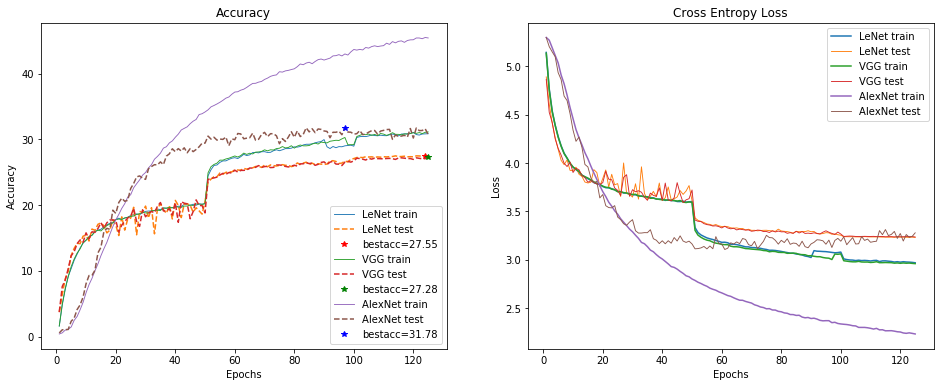

In [10]:
LeNet=np.load('LeNet.npy')
AlexNet=np.load('AlexNet.npy')
VGG=np.load('VGG.npy')
epochs=np.arange(1,LeNet.shape[1]+1,1)
plt.figure(figsize=(16.,6.))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,LeNet[2],label='LeNet train',linewidth=0.9)
plt.plot(epochs,LeNet[3],label='LeNet test',linestyle='--')
ep=np.argmax(LeNet[3,:])
plt.plot(ep+1,LeNet[3,ep],'r*',label='bestacc=%.2f'%LeNet[3,ep])
plt.plot(epochs,VGG[2],label='VGG train',linewidth=0.9)
plt.plot(epochs,VGG[3],label='VGG test',linestyle='--')
ep=np.argmax(VGG[3,:])
plt.plot(ep+1,VGG[3,ep],'g*',label='bestacc=%.2f'%VGG[3,ep])
plt.plot(epochs,AlexNet[2],label='AlexNet train',linewidth=0.9)
plt.plot(epochs,AlexNet[3],label='AlexNet test',linestyle='--')
ep=np.argmax(AlexNet[3,:])
plt.plot(ep+1,AlexNet[3,ep],'b*',label='bestacc=%.2f'%AlexNet[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,LeNet[0],label='LeNet train')
plt.plot(epochs,LeNet[1],label='LeNet test',linewidth=0.9)
plt.plot(epochs,VGG[0],label='VGG train')
plt.plot(epochs,VGG[1],label='VGG test',linewidth=0.9)
plt.plot(epochs,AlexNet[0],label='AlexNet train')
plt.plot(epochs,AlexNet[1],label='AlexNet test',linewidth=0.9)
plt.legend()
plt.savefig('CNNs_1.png')
plt.show()

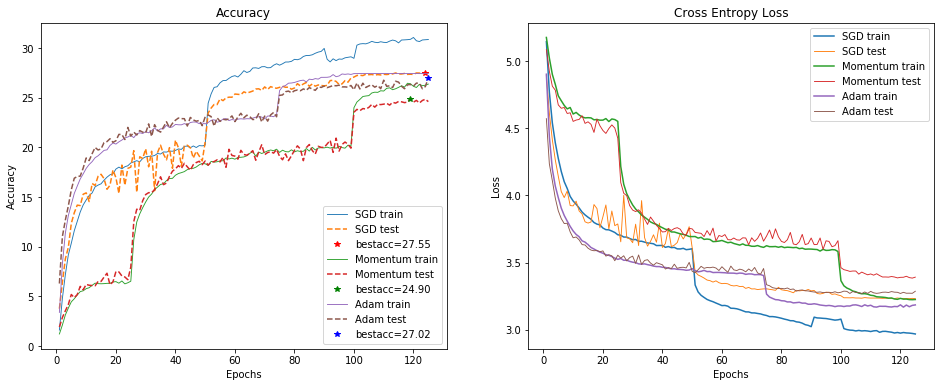

In [20]:
LeNet=np.load('LeNet.npy')
LeNet_momentum=np.load('LeNet_momentum.npy')[:,:125]
LeNet_adam=np.load('LeNet_adam.npy')
epochs=np.arange(1,LeNet.shape[1]+1,1)
plt.figure(figsize=(16.,6.))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,LeNet[2],label='SGD train',linewidth=0.9)
plt.plot(epochs,LeNet[3],label='SGD test',linestyle='--')
ep=np.argmax(LeNet[3,:])
plt.plot(ep+1,LeNet[3,ep],'r*',label='bestacc=%.2f'%LeNet[3,ep])
plt.plot(epochs,LeNet_momentum[2],label='Momentum train',linewidth=0.9)
plt.plot(epochs,LeNet_momentum[3],label='Momentum test',linestyle='--')
ep=np.argmax(LeNet_momentum[3,:])
plt.plot(ep+1,LeNet_momentum[3,ep],'g*',label='bestacc=%.2f'%LeNet_momentum[3,ep])
plt.plot(epochs,LeNet_adam[2],label='Adam train',linewidth=0.9)
plt.plot(epochs,LeNet_adam[3],label='Adam test',linestyle='--')
ep=np.argmax(LeNet_adam[3,:])
plt.plot(ep+1,LeNet_adam[3,ep],'b*',label='bestacc=%.2f'%LeNet_adam[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.title('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,LeNet[0],label='SGD train')
plt.plot(epochs,LeNet[1],label='SGD test',linewidth=0.9)
plt.plot(epochs,LeNet_momentum[0],label='Momentum train')
plt.plot(epochs,LeNet_momentum[1],label='Momentum test',linewidth=0.9)
plt.plot(epochs,LeNet_adam[0],label='Adam train')
plt.plot(epochs,LeNet_adam[1],label='Adam test',linewidth=0.9)
plt.legend()
plt.savefig('CNNs_2.png')
plt.show()